In [14]:
import time
import datetime

import pandas as pd

from google.colab import auth
from google.cloud import bigquery
from google.colab import data_table

import logging

log = logging.getLogger(__name__)
logging.basicConfig(level=logging.DEBUG)

In [2]:
project = "fauxpas"
location = "US"
client = bigquery.Client(project=project, location=location)

data_table.enable_dataframe_formatter()
auth.authenticate_user()

In [19]:
priority = bigquery.QueryPriority.BATCH #or bigquery.QueryPriority.INTERACTIVE
dry_run = False #or True

job_config = bigquery.QueryJobConfig(
    dry_run=dry_run,
    use_query_cache=False,
    priority=priority
)

def run_query(query):
  query_job = client.query(
      query,
      job_config=job_config,
  )

  print("This query will process {:,} GB.".format(query_job.total_bytes_processed or 0 / 1_000_000_000))
  approved = input("y/n? ")

  if approved != "y":
    raise Exception("Not approved by user")

  for i in range(100):
    query_job = client.get_job(
      query_job.job_id, location=query_job.location
    )

    if query_job.state == "DONE":
      break

    print(datetime.datetime.utcnow().isoformat(), "processing", query_job.job_id, "status", query_job.state)
    time.sleep(10)

  return query_job.to_dataframe()

In [35]:
query = """
  SELECT
  AVG(receipt_effective_gas_price) as eff_gas_wei_avg,
  AVG(max_fee_per_gas) as max_fee_avg,
  AVG(receipt_cumulative_gas_used) as gas_used_avg,
  AVG(gas_price) as gas_price_avg,

  block_timestamp
  FROM `bigquery-public-data.crypto_ethereum.transactions`
  WHERE cast(block_timestamp as DATETIME) >= DATE_SUB(CURRENT_DATE(), INTERVAL 2 YEAR)
  GROUP BY block_timestamp
"""


df = run_query(query)

This query will process 0.0 GB.
y/n? y
2023-09-12T11:42:52.501897 processing 50fe6802-23b9-4999-89de-55b78746853f status RUNNING
2023-09-12T11:43:02.647610 processing 50fe6802-23b9-4999-89de-55b78746853f status RUNNING


In [36]:
res_df_mean = df.set_index('block_timestamp').groupby(pd.Grouper(freq="D")).mean()

Should be 2USD / 1600USD/ETH = 0.00125 ETH
..., but we dont have gas price, only tx price in Wei


<Axes: xlabel='block_timestamp'>

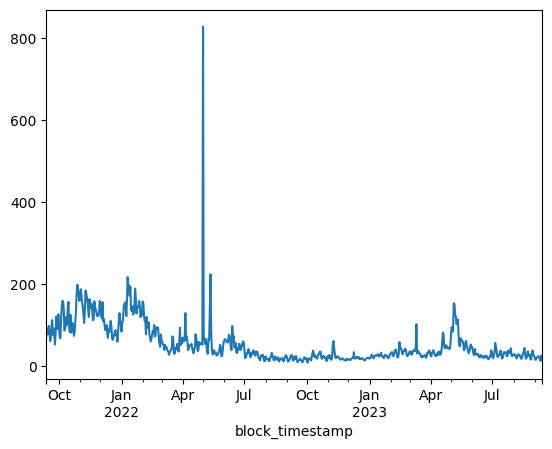

In [42]:
print("Should be 2USD / 1600USD/ETH = 0.00125 ETH")
print("..., but we dont have gas price, only tx price in Wei")
eth_to_gwei = 1 / 1_000_000_000
wei_to_gwei = 1 / 1_000_000_000

(res_df_mean.eff_gas_wei_avg * wei_to_gwei).plot()